<a href="https://colab.research.google.com/github/ras1364/Fake-Review-Using-BERT/blob/main/FakeReviewDetectionUsingBertVer3-0-0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

In [ ]:
data = pd.read_csv("/content/sample_data/deceptive-opinion.csv")
#data.head()

In [ ]:
data['polarity'] = np.where(data['polarity']=='positive',1,0)
data['deceptive'] = np.where(data['deceptive']=='truthful', 1,0)
#data.head()

In [ ]:
df = data.sample(frac=1)
#df.head()

In [ ]:
#df.describe()

In [ ]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]
    
def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)
#data['final_class']

In [ ]:
#data['given_class']

In [ ]:
#data.head()

In [ ]:
# Number of sentece in each review 
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

for sen in data.text:
  data["NumberOfSentece"] = len(sent_tokenize(sen))
#data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
sum =0
for a in data.NumberOfSentece:
  sum += a
print("Average number of reviews : ", sum/len(data), "  Sum = ",sum , "  Length = ", len(data) )

Average number of reviews :  13.0   Sum =  20800   Length =  1600


In [ ]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
data['given_class']= label_encoder.fit_transform(data['given_class']) 
data['given_class'].unique()

array([3, 1, 2, 0])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
Y = data['given_class']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13


In [ ]:
textData = pd.DataFrame(list(data['text'])) # each row is one document; the raw text of the document should be in the 'text_data' column
textData.head()

,0
0,We stayed for a one night getaway with family ...
1,Triple A rate with upgrade to view room was le...
2,This comes a little late as I'm finally catchi...
3,The Omni Chicago really delivers on all fronts...
4,I asked for a high floor away from the elevato...


In [ ]:
# initialize stemmer
stemmer = snowballstemmer.EnglishStemmer()

# grab stopword list, extend it a bit, and then turn it into a set for later
nltk.download('stopwords')
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#remove characters and stoplist words, then generate dictionary of unique words
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]    
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class,NumberOfSentece,stemmed_text_data
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3,13,stay night getaway famili thursday tripl aaa r...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3,13,tripl rate upgrad view room less $ includ brea...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3,13,come littl late final catch review past sever ...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3,13,omni chicago realli deliv front spacious room ...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3,13,ask high floor away elev got room pleasant dec...


In [ ]:
data["given_class"].value_counts()

3    400
1    400
2    400
0    400
Name: given_class, dtype: int64

In [ ]:
data['length']=data['stemmed_text_data'].apply(len)
#data.head()

In [ ]:
print("The most words in a sentence = ",data.length.max())

The most words in a sentence =  2300


In [ ]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2999c10a68f7b86f81bdd91dbb88becd09fa47d0e31803721182bfc8454eac49
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/sentence-t5-base')

text = ['This is a sentence to get vector', 'This one too']
inputs = tokenizer(text, return_tensors='tf', padding=True)
inputs

{'input_ids': <tf.Tensor: shape=(2, 9), dtype=int32, numpy=
array([[  100,    19,     3,     9,  7142,    12,   129, 12938,     1],
       [  100,    80,   396,     1,     0,     0,     0,     0,     0]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 9), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0]], dtype=int32)>}

In [ ]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()
# inputs_tf = {'input_ids': inputs['input_ids'], 'attention_mask': inputs['attention_mask']}
#output =  sbert_model(inputs_tf)

In [ ]:
sentence_embeddings = sbert_model.encode(data.stemmed_text_data ,  show_progress_bar=True)
sentence_embeddings

Batches:   0%|          | 0/50 [00:00<?, ?it/s]

array([[-0.02988991, -0.03472561,  0.03928245, ...,  0.02575624,
        -0.05594918, -0.05019124],
       [ 0.0170337 , -0.02699246,  0.03634839, ..., -0.04633627,
        -0.10250886,  0.01035914],
       [ 0.03260773, -0.00507131,  0.05966509, ...,  0.01608947,
        -0.07991598,  0.01620163],
       ...,
       [ 0.0376084 , -0.02132958, -0.00323072, ..., -0.0224402 ,
        -0.08832183, -0.02594899],
       [-0.0200915 ,  0.02683769,  0.02028533, ..., -0.01267937,
        -0.01757715,  0.00845783],
       [ 0.04713808, -0.01480141,  0.05658682, ...,  0.02701328,
        -0.04195021, -0.00324717]], dtype=float32)

In [ ]:
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(model_name)

# text = ['This is a sentence to get vector', 'This one too']
# inputs = tokenizer(text, return_tensors='tf', padding=True)

# inputs_tf = {'input_ids': inputs['input_ids'], 'input_mask': inputs['attention_mask']}
# outputs_tf = model(inputs_tf)
# print("Sentence vector", outputs_tf['sentence_vector'].shape)

In [ ]:
from sklearn.model_selection import train_test_split
X = sentence_embeddings
y = data["deceptive"]


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y)

In [ ]:
total_words = 0
for i in data.length:
      total_words += i
total_words

689262

In [ ]:
sentence_embeddings.shape

(1600, 384)

In [ ]:
import tensorflow as tf

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
# define and fit the final model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
   ] 
model = Sequential()
model.add(Dense(64, input_shape=(384,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
model.fit(X_train,y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
19/19 [==============================] - 3s 11ms/step - loss: 0.6817 - accuracy: 0.6308 - precision: 0.7199 - recall: 0.4283
Epoch 2/50
19/19 [==============================] - 0s 9ms/step - loss: 0.6455 - accuracy: 0.7108 - precision: 0.7598 - recall: 0.6167
Epoch 3/50
19/19 [==============================] - 0s 8ms/step - loss: 0.5906 - accuracy: 0.7317 - precision: 0.7473 - recall: 0.7000
Epoch 4/50
19/19 [==============================] - 0s 10ms/step - loss: 0.5333 - accuracy: 0.7625 - precision: 0.7578 - recall: 0.7717
Epoch 5/50
19/19 [==============================] - 0s 11ms/step - loss: 0.4841 - accuracy: 0.7867 - precision: 0.7966 - recall: 0.7700
Epoch 6/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4425 - accuracy: 0.8092 - precision: 0.8149 - recall: 0.8000
Epoch 7/50
19/19 [==============================] - 0s 15ms/step - loss: 0.4127 - accuracy: 0.8225 - precision: 0.8319 - recall: 0.8083
Epoch 8/50
19/19 [==============================] 

In [ ]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 3ms/step - loss: 0.7557 - accuracy: 0.7825 - precision: 0.7927 - recall: 0.7650


[0.7557480335235596,
 0.7825000286102295,
 0.7927461266517639,
 0.7649999856948853]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 0s 2ms/step


In [ ]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted


array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[160,  40],
       [ 47, 153]])

Text(33.0, 0.5, 'Truth')

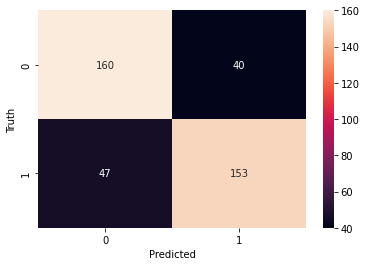

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       200
           1       0.79      0.77      0.78       200

    accuracy                           0.78       400
   macro avg       0.78      0.78      0.78       400
weighted avg       0.78      0.78      0.78       400



In [ ]:
y_test

628     0
1532    0
921     1
901     1
1427    0
       ..
83      1
178     1
875     1
1141    1
1120    1
Name: deceptive, Length: 400, dtype: int64